In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

In [49]:
#data cleaning and wrangling

reviews=pd.read_csv('/Users/anna/Downloads/reviews.csv.gz',compression='gzip').dropna()
listings=pd.read_csv('/Users/anna/Downloads/listings (1).csv',error_bad_lines=False)
neighborhoods=pd.read_csv('/Users/anna/Downloads/neighbourhoods.csv',error_bad_lines=False)
crime=pd.read_csv('/Users/anna/Downloads/crime rates.csv',error_bad_lines=False).dropna()

inactive=listings.loc[listings.availability_365==365]
inactive.set_index('id',inplace=True)
listings.set_index('id',inplace=True)
new_listings=listings.drop(inactive.index,axis=0)

autopost_1=reviews[reviews.comments.str.contains('The host canceled my reservation')]
autopost_2=reviews[reviews.comments.str.contains('This is an automated posting')]
autopost=pd.concat([autopost_1,autopost_2], axis=0).reset_index()


def days_count(text):
    if 'the day before' in text:
        return 1
    else:
        return int(re.findall('\d+', text)[0])
    
total_days=pd.DataFrame(autopost.comments.apply(days_count))

auto=pd.merge(autopost,total_days,how='left',left_index=True,right_index=True)

avg_days=pd.DataFrame(auto[['listing_id','comments_y']].groupby('listing_id')['comments_y'].apply(np.mean).apply(round))


canceled=autopost.listing_id.value_counts()
num_cancel=canceled.to_frame(name='cancellations')
new_listings['num_cancellations']=num_cancel

booked=365-new_listings.availability_365
booked=booked.to_frame('days booked')
df=new_listings.merge(booked, how='left',left_index=True,right_index=True)
df['days_cancelled_avg']=avg_days
df=df[['neighbourhood','room_type','price','minimum_nights','number_of_reviews'\
       ,'calculated_host_listings_count','days booked','num_cancellations','days_cancelled_avg']]
df['num_cancellations']=df.num_cancellations.fillna(0)
df['days_cancelled_avg']=df.days_cancelled_avg.fillna(0)


conv = lambda x: float(x.replace(',',''))
crime['Number_of_offences']=crime.Number_of_offences.apply(conv)
all_crimes=crime[crime['Offences']=='All recorded offences']

all_crimes=all_crimes[all_crimes['Borough']!='Inner London']
all_crimes=all_crimes[all_crimes['Borough']!='England and Wales']
all_crimes=all_crimes[all_crimes['Borough']!='Met Police Area']
all_crimes=all_crimes[all_crimes['Borough']!='Outer London']
all_crimes=all_crimes[all_crimes['Borough']!='Heathrow']

conv_fl = lambda x: int(x.replace('-',''))
year = all_crimes.Year.apply(conv_fl)
all_crimes['Year']=year
latest=all_crimes[(all_crimes['Year'])>=201112]


In [73]:
df_main=pd.merge(df,latest.groupby('Borough').mean(),left_on='neighbourhood',right_on='Borough',how='left').drop(columns=['Year','Number_of_offences'])

Since scikit learn rejects categorical features by default, we make sure to create dummies for these categorical features. In this data, we only have two categorical variables: 'room_type' and 'neighborhood'.

In [45]:
#create dummies

df=df_main

categories=['room_type','neighbourhood']

for category in categories:
    df[category]=df[category].astype('category')
    
new_df=pd.get_dummies(df,drop_first=True)

X=new_df.drop(columns=['calculated_host_listings_count', 'num_cancellations'])
take_log = lambda x: np.log(x) if x>0 else 0
y=new_df.num_cancellations

We will use 70% of the data as the training data and use the remaining as the test set.

We will fit the training set to different estimators and see which one performs best without any hyperparameter tuning.

## Linear Regression

In [5]:
X=X.fillna(0)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

cv_scores= cross_val_score(reg, X_train, y_train, cv=5,scoring='r2')*100


print('Linear Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())

model_results={}
model_results['Linear Regression']=cv_scores.mean()


Linear Regression Cross-Validation Scores:
 [22.18290634 21.45658224 22.31404306 23.18851301 21.58131627]
Average Score on 5-Folds: 22.14%


There are three regression metrics we can use: 
    1) Mean Absolute Error
    2) Mean Squared Error
    3) R^2
    
For this project, I use R^2 for scoring since this will show us the goodness of fit of our prediction compared to the actual values.

## Ridge Regression

In [7]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_train, y_train)

cv_scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring="r2")*100

print('Ridge Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())


model_results['Ridge Regression']=cv_scores.mean()


Ridge Regression Cross-Validation Scores:
 [22.18357609 21.45695862 22.3143243  23.18951628 21.58131959]
Average Score on 5-Folds: 22.15%


## Lasso Regression

In [8]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=42)
lasso.fit(X_train, y_train)

cv_scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring="r2")*100



print('Lasso Regression Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % (cv_scores.mean()))


model_results['Lasso Regression']=(cv_scores.mean())


Lasso Regression Cross-Validation Scores:
 [21.07450804 21.11753366 21.89647552 22.65601087 21.44237983]
Average Score on 5-Folds: 21.64%


## Decision Trees

In [9]:
from sklearn import tree
from sklearn.ensemble import BaggingRegressor

trees = tree.DecisionTreeRegressor(random_state=42)
trees.fit(X_train, y_train)

bag = BaggingRegressor(base_estimator=trees, random_state=42)
bag.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(bag, X_train, np.ravel(y_train), cv=5, scoring="r2")*100

print('Decision Trees Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())


model_results['Decision Trees']=cv_scores.mean()


Decision Trees Cross-Validation Scores:
 [54.4217324  58.96705215 59.87329344 61.57846697 56.81836209]
Average Score on 5-Folds: 58.33%


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(rf, X_train, np.ravel(y_train), cv=5, scoring="r2")*100


print('Random Forest Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())

model_results['Random Forest']=cv_scores.mean()

/Users/anna/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Cross-Validation Scores:
 [55.25761186 58.95332487 58.85265788 60.76294835 56.2914201 ]
Average Score on 5-Folds: 58.02%


## Gradient Boost 

In [11]:

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(gbr, X_train, np.ravel(y_train),cv=5, scoring="r2")*100

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())

model_results['Gradient Boost']=cv_scores.mean()

Gradient Boost Cross-Validation Scores:
 [59.62670019 63.52494721 61.51806975 68.42969262 63.00312336]
Average Score on 5-Folds: 63.22%


In the dictionary below, we see how well each estimator did.

In [12]:
model_results

{'Linear Regression': 22.14467218232928,
 'Ridge Regression': 22.145138975618472,
 'Lasso Regression': 21.637381583468162,
 'Decision Trees': 58.33178140921795,
 'Random Forest': 58.02359261222873,
 'Gradient Boost': 63.22050662448341}

Text(0, 0.5, 'Mean CV Scores')

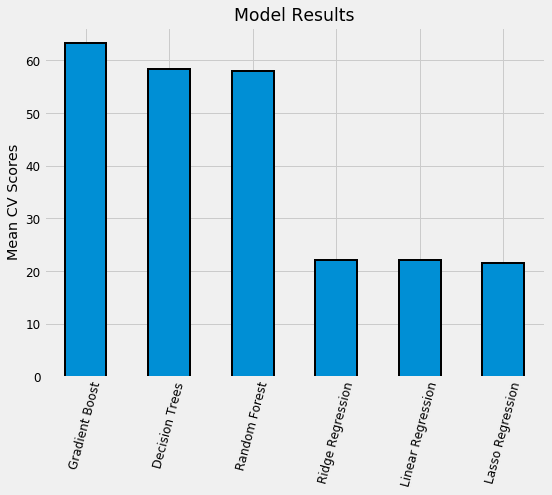

In [28]:
results=pd.DataFrame.from_dict(model_results,orient='index',columns=['cv_mean'])
results=results.sort_values('cv_mean',ascending=False)
results['cv_mean'].plot.bar(figsize = (8, 6), edgecolor = 'k', linewidth = 2)
plt.xticks(rotation=75)
plt.title('Model Results')
plt.ylabel('Mean CV Scores')

The Gradient Boosting Regressor returned the highest cross validation score average. We try to extract best performance from this model by hyperparameter tuning.

## Feature Importance

Despite not having a lot of features to start with (40), we can improve the model's performance by dropping features that do not improve its performance and could even cause an overfitting.

In [14]:
features=X_train.columns

In [15]:
# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_})
feature_importances.sort_values(by='importance',ascending=False)

,feature,importance
4,days_cancelled_avg,0.676218
2,number_of_reviews,0.078718
0,price,0.067696
3,days booked,0.056675
1,minimum_nights,0.026000
5,Rate,0.018954
38,room_type_Private room,0.007126
26,neighbourhood_Lambeth,0.005529
17,neighbourhood_Hammersmith and Fulham,0.005451
24,neighbourhood_Kensington and Chelsea,0.005236


In [29]:
def plot_feature_importances(df, n = 10, threshold = None):
   
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show()
        
        
    
    return df


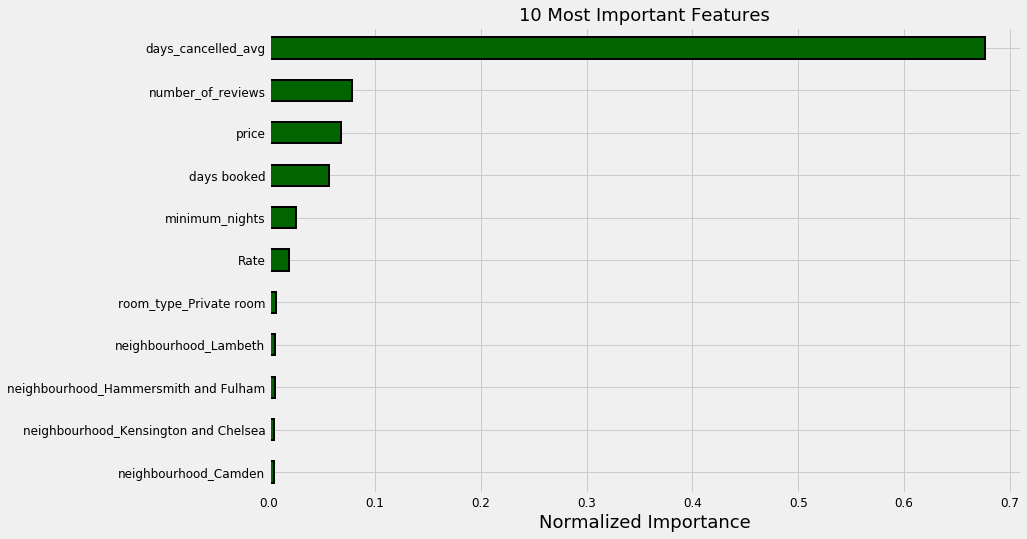

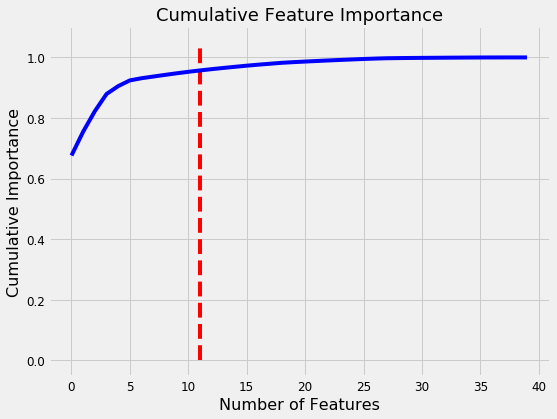

In [17]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

As we can see, the noncategorical feature that has least feature importance is 'Rate' (neighborhood's crime rate).

In [18]:
#create dummies

categories=['room_type','neighbourhood']

for category in categories:
    df_main[category]=df_main[category].astype('category')
    
new=pd.get_dummies(df_main,drop_first=True).drop(columns=['Rate'])

X2=new.drop(columns=['calculated_host_listings_count', 'num_cancellations'])
take_log = lambda x: np.log(x) if x>0 else 0
y2=new.num_cancellations

In [19]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [20]:
gbr2 = GradientBoostingRegressor(random_state=42)
gbr2.fit(X2_train, np.ravel(y2_train))

cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())

Gradient Boost Cross-Validation Scores:
 [59.57090959 63.59085202 62.21542703 68.49382006 62.91017175]
Average Score on 5-Folds: 63.36%


By dropping the feature 'Rate', our average CV score went up from 63.22% to 63.36%

## Hyperparameter Tuning

In [21]:
trees=[50,100,200,300,400,500]

gbr_results={}

for tree in trees:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=tree)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    gbr_results[tree]=cv_scores.mean()
    
best_n=[a for a,b in gbr_results.items() if b==max(gbr_results.values())][0]

In [22]:
depth= list(range(3,8))

depth_results={}

for x in depth:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=x)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    depth_results[x]=cv_scores.mean()
    
best_max_depth=[a for a,b in depth_results.items() if b==max(depth_results.values())][0]

In [23]:
lr=[0.0001, 0.001, 0.01, 0.1]

lr_results={}

for x in lr:
    gbr2 = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=best_max_depth,learning_rate=x)
    gbr2.fit(X2_train, np.ravel(y2_train))

    cv_scores = cross_val_score(gbr2, X2_train, np.ravel(y2_train),cv=5, scoring="r2")*100
    lr_results[x]=cv_scores.mean()
    
best_lr=[a for a,b in lr_results.items() if b==max(lr_results.values())][0]


In [24]:
gbr = GradientBoostingRegressor(random_state=42,n_estimators=best_n,max_depth=best_max_depth,learning_rate=best_lr)
gbr.fit(X_train, np.ravel(y_train))

cv_scores = cross_val_score(gbr, X_train, np.ravel(y_train),cv=5, scoring="r2")*100

print('Gradient Boost Cross-Validation Scores:\n',cv_scores)
print("Average Score on 5-Folds: %.2f%%" % cv_scores.mean())


Gradient Boost Cross-Validation Scores:
 [59.7238846  63.56865243 62.41252428 68.59574476 63.30150423]
Average Score on 5-Folds: 63.52%


In [83]:
train_score = gbr.score(X_train, y_train)*100
test_score = gbr.score(X_test, y_test)*100

print("Train set score: %.2f%%" % train_score)
print("Test set score: %.2f%%" % test_score)

Train set score: 64.60%
Test set score: 61.45%
